<a href="https://colab.research.google.com/github/GGANCC1/voice_emotion_recognition/blob/main/audiomfccreq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 총 길이   : 194899.7973333329
# 파일 갯수 : 33980
# 평균 길이 : 5.735720933882663
#구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Apr 25 06:30:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import torch
torch.cuda.is_available() 

True

In [ ]:
# import package
import os
import gc
import glob
import librosa
import numpy as np
import pandas as pd
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

43991


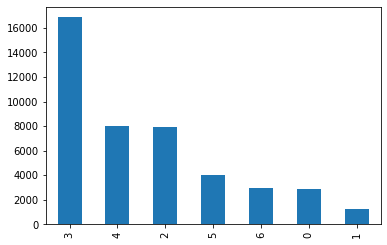

In [ ]:
import pandas as pd
from glob import glob
from collections import Counter

AUDIO_PATH = '/content/drive/MyDrive/감정 분류를 위한 대화 음성 데이터셋/4차년도+5차년도_2차/'

files = glob('/content/drive/MyDrive/감정 분류를 위한 대화 음성 데이터셋/' + '*.csv')

temp = []
for i in files:
  temp.append(pd.read_csv(i, encoding='cp949'))
text_emotion_data = pd.concat(temp)
text_emotion_data = text_emotion_data.reset_index(drop=True)

print(len(text_emotion_data))

text_emotion_data['1번 감정'] = text_emotion_data['1번 감정'].str.upper()
text_emotion_data['2번 감정'] = text_emotion_data['2번 감정'].str.upper()
text_emotion_data['3번 감정'] = text_emotion_data['3번 감정'].str.upper()
text_emotion_data['4번 감정'] = text_emotion_data['4번 감정'].str.upper()
text_emotion_data['5번 감정'] = text_emotion_data['5번 감정'].str.upper()
text_emotion_data['label'] = text_emotion_data.apply(lambda row : Counter([row['1번 감정'], row['2번 감정'], row['3번 감정'], row['4번 감정'], row['5번 감정']]).most_common(1)[0][0], axis=1)

text_emotion_data.loc[(text_emotion_data['label'] == "FEAR"), 'label'] = 0  #공포 => 0
text_emotion_data.loc[(text_emotion_data['label'] == "SURPRISE"), 'label'] = 1  #놀람 => 1
text_emotion_data.loc[(text_emotion_data['label'] == "ANGRY"), 'label'] = 2  #분노 => 2
text_emotion_data.loc[(text_emotion_data['label'] == "SADNESS"), 'label'] = 3  #슬픔 => 3
text_emotion_data.loc[(text_emotion_data['label'] == "NEUTRAL"), 'label'] = 4  #중립 => 4
text_emotion_data.loc[(text_emotion_data['label'] == "HAPPINESS"), 'label'] = 5  #행복 => 5
text_emotion_data.loc[(text_emotion_data['label'] == "DISGUST"), 'label'] = 6  #혐오 => 6

## 파일명이랑 다른 wav_id 매핑
wav_id_map = '''5e38d5fe05fef317e874c705	5e3292655807b852d9e03896
5e39383fdbc4b7182a6aa5f4	5e2ad43e5807b852d9e020dc
5e38d655dbc4b7182a6aa405	5e3292825807b852d9e0389a
5e37e25905fef317e874c12e	5e33638b5807b852d9e04aeb
5e38a1d805fef317e874c5f7	5e298bc45807b852d9e01a10
5e38d5c133e9ad176cc9b8e5	5e32924e5807b852d9e03894
5e393e55ee8206179943d383	5e3161c65807b852d9e032af
5e37da3e33e9ad176cc9b2b1	5e2998b85807b852d9e01b02
5e3937ab05fef317e874c913	5e2ad4145807b852d9e020d9
5e38a184c8c25f16cd145d22	5e298b9f5807b852d9e01a0f
5e37def1dbc4b7182a6a9e44	5e2979c25807b852d9e018d5
5e380ef305fef317e874c3b5	5e315dca5807b852d9e03275
5e37e2f005fef317e874c13e	5e33a9d35807b852d9e050f4
5e38a2037995ef170fc0f96c	5e298bdc5807b852d9e01a11
5e38a219c8c25f16cd145d25	5e298c085807b852d9e01a12
5e393ea333e9ad176cc9bae6	5e31622f5807b852d9e032ba'''.split('\n')
wav_id_map = {ids.split('\t')[1]:ids.split('\t')[0] for ids in wav_id_map}
text_emotion_data['wav_id'] = text_emotion_data['wav_id'].apply(lambda wid: wav_id_map[wid] if wid in wav_id_map else wid)

text_emotion_data['label'].value_counts().plot(kind='bar')

In [ ]:
wav_list = text_emotion_data["wav_id"].tolist()
label_list = text_emotion_data["label"].tolist()

del text_emotion_data
gc.collect()

103

In [ ]:
def get_label(filename):
    idx = wav_list.index(filename)
    return label_list[idx]

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_pad_len = 1000

def extract_feature(file_name):
    try:
        audio, sr = librosa.load(AUDIO_PATH + file_name + '.wav', res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=100)
        padded_mfccs = pad_sequences(mfccs, padding='post', maxlen=max_pad_len)     
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        print(e);
        return None
    return padded_mfccs

In [ ]:
features = []
count = 0
observed_emotions = [2, 3, 4, 5]

for file_name in wav_list:
  class_label = get_label(file_name)
  if class_label not in observed_emotions:
    continue
  data = extract_feature(file_name)
  features.append([data, class_label])
  count+=1
  print(count)
  
# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

del features
gc.collect()

In [ ]:
featuresdf

,feature,class_label
0,"[[-639, -639, -639, -639, -639, -635, -634, -6...",2
1,"[[-657, -657, -657, -650, -535, -491, -492, -4...",3
2,"[[-649, -649, -623, -602, -599, -596, -591, -5...",3
3,"[[-630, -630, -630, -630, -628, -621, -618, -6...",2
4,"[[-649, -649, -649, -642, -608, -595, -591, -5...",3
...,...,...
36908,"[[-896, -896, -896, -891, -830, -811, -823, -8...",3
36909,"[[-926, -926, -926, -922, -878, -840, -814, -8...",3
36910,"[[-870, -870, -870, -852, -744, -715, -747, -7...",3
36911,"[[-906, -906, -906, -901, -867, -835, -828, -8...",3


In [ ]:
# 피클로 데이터 저장
featuresdf.to_pickle("/content/drive/MyDrive/감정 분류를 위한 대화 음성 데이터셋/피클/featuresdf4_5_2_4.pkl")

In [ ]:
# 피클 데이터 로드
featuresdf = pd.read_pickle("/content/drive/MyDrive/감정 분류를 위한 대화 음성 데이터셋/피클/featuresdf4_5_2_3.pkl")

In [ ]:
len(featuresdf.loc[0].feature[0])

1000

In [ ]:
from tensorflow.keras.utils import to_categorical

X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [ ]:
del featuresdf
gc.collect()

252

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [ ]:
n_columns = 1000
n_row = 40       
n_channels = 1
n_classes = 4

# input shape
with tf.device('/device:GPU:0'):
    x_train = tf.reshape(x_train, [-1, n_row, n_columns, n_channels])
    x_test = tf.reshape(x_test, [-1, n_row, n_columns, n_channels])

In [ ]:
model = keras.Sequential()

model.add(layers.Conv2D(input_shape=(n_row, n_columns, n_channels), filters=16, kernel_size=2, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(kernel_size=2, filters=32, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(kernel_size=2, filters=64, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(kernel_size=2, filters=128, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.2))

model.add(layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(units=4, activation='softmax'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 39, 999, 16)       80        
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 19, 499, 16)      0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 19, 499, 16)       0         
                                                                 
 conv2d_52 (Conv2D)          (None, 18, 498, 32)       2080      
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 9, 249, 32)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 9, 249, 32)      

In [ ]:
model = keras.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3, 3), input_shape=(n_row, n_columns, n_channels), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(n_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

In [ ]:
model = keras.Sequential()

model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape= (n_row, n_columns, n_channels)))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

model.summary()

In [ ]:
from keras.callbacks import EarlyStopping

training_epochs = 300
num_batch_size = 128

learning_rate = 0.001
opt = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=training_epochs)

# early_stopping = EarlyStopping(monitor='loss', patience=100, mode='auto')
# loss값을 모니터해서 과적합이 생기면 100번 더 돌고 끊음
# mode=auto loss면 최저값이100번정도 반복되면 정지, acc면 최고값이 100번정도 반복되면 정지
# mode=min, mode=max
# model.fit(x, y, epochs=100, batch_size=num_batch_size, verbose=2, callbacks=[early_stopping])

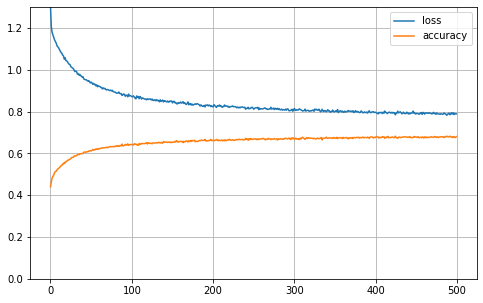

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.3)
#save_fig("keras_learning_curves_plot")
plt.show()

In [ ]:
print('\n# Evaluate on test data')
results = model.evaluate(x_test, y_test, batch_size=128)
print('test loss, test acc:', results)


# Evaluate on test data
58/58 [==============================] - 2s 37ms/step - loss: 0.9209 - accuracy: 0.6245
test loss, test acc: [0.9208711385726929, 0.6245428919792175]


In [ ]:
y_test

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [ ]:
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score , recall_score , confusion_matrix

y_pred = []
y_true = []

pred = model.predict(x_test)

for list in pred:
  for i in range(0,4):
    if(max(list)==list[i]):
      y_pred.append(i)
for list in y_test:
  for i in range(0,4):
    if(list[i] == 1):
      y_true.append(i)

precision = precision_score(y_true, y_pred,average= "weighted")
recall = recall_score(y_true, y_pred,average= "weighted")
print('정밀도: {0:.4f}, 재현율: {1:.4f}'.format(precision, recall))
print('f1-score : ' + str(f1_score(y_true, y_pred, average='weighted')))

정밀도: 0.6190, 재현율: 0.6245
f1-score : 0.6108408391281119


In [ ]:
model.save("/content/drive/MyDrive/감정 분류를 위한 대화 음성 데이터셋/피클/sound_classifier_model")